In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
from tqdm import tqdm

In [69]:
home_path = '../dataset'
# img_size = 544
img_w, img_h = 1360, 800

In [70]:
files_list = os.listdir(home_path)
files_list.sort()
print(f'Total Image Files: {int(len(files_list) / 2)}')

Total Image Files: 741


In [71]:
def cal_mode(X):
    idx, cnts = np.unique(X, return_counts=True)
    nid = np.argmax(cnts)
    return idx[nid]

def get_img_path(f_name):
    fn_list = f_name.split('.')
    img_name, ext = '.'.join(fn_list[:-1]), fn_list[-1]
    for extension in ['.jpg', '.png']:
        img_path = os.path.join(home_path, img_name+extension)
        if os.path.isfile(img_path):
            return img_path
        
        
def get_img_vals(img_path):
    pil_img = Image.open(img_path)
    np_img = np.asarray(pil_img)
    
    raf = np_img[..., 0]
    gaf = np_img[..., 1]
    baf = np_img[..., 2]
    
    r_mode = cal_mode(raf)
    g_mode = cal_mode(gaf)
    b_mode = cal_mode(baf)
    
    #print(r_mode, g_mode, b_mode)
    return (r_mode, g_mode, b_mode)
    
    # plt.imshow(pil_img)
    # plt.show()

In [73]:
total_list = []

class_file = os.path.join(home_path, 'classes.txt')
with open(class_file) as fc:
    class_list = fc.readlines()

for file_name in tqdm(files_list[:10]):
    if file_name.endswith('.txt') and not file_name.startswith('class'):
        file_path = os.path.join(home_path, file_name)
        
        im_path = get_img_path(file_name)
        im_r_mode, im_g_mode, im_b_mode = get_img_vals(im_path)
        # print(im_r_mode, im_g_mode, im_b_mode)
        
        with open(file_path) as fp:
            # print(file_name)
            file_data = fp.readlines()
            for data_list in file_data:
                data_item = data_list.split(' ')
                try:
                    total_list.append([
                        file_path,
                        
                        #img_size * img_size,
                        #img_size,
                        #img_size,
                        img_w * img_h,
                        img_w,
                        img_h,
                        
                        class_list[int(data_item[0])].replace('\n', ''),
                        int(data_item[0]),
                        
                        int(im_r_mode),
                        int(im_g_mode),
                        int(im_b_mode),
                        
                        float(data_item[1]),
                        float(data_item[2]),
                        float(data_item[3]),
                        float(data_item[4])
                    ])
                except IndexError:
                    print('\nClass names must match with # of objects')
                    print('Please check your object labels or total of class names.\n')
                    exit(0)

df = pd.DataFrame(data=total_list,
                  columns=['img_path',
                           
                           'img_size',
                           'img_width',
                           'img_height',
                           
                           'class_name',
                           'class_idx',
                           
                           'r_mode',
                           'g_mode',
                           'b_mode',
                           
                           'ncx',
                           'ncy',
                           'nbw',
                           'nbh'
                          ])


#df['cx'], df['cy'], df['bw'], df['bh'] = df.ncx * img_size, df.ncy * img_size, df.nbw * img_size, df.nbh * img_size
df['cx'], df['cy'], df['bw'], df['bh'] = df.ncx * img_w, df.ncy * img_h, df.nbw * img_w, df.nbh * img_h

df['obj_px'] = df['bw'] * df['bh']
df['obj_img_ratio'] = df['obj_px'] / df['img_size']

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 17.45it/s]


In [74]:
df.head()

,img_path,img_size,img_width,img_height,class_name,class_idx,r_mode,g_mode,b_mode,ncx,ncy,nbw,nbh,cx,cy,bw,bh,obj_px,obj_img_ratio
0,../dataset/00000.txt,1088000,1360,800,danger,1,255,255,255,0.584191,0.535625,0.030147,0.04375,794.5,428.5,41.0,35.0,1435.0,0.001319
1,../dataset/00001.txt,1088000,1360,800,mandatory,2,255,255,255,0.737868,0.512500,0.030147,0.05500,1003.5,410.0,41.0,44.0,1804.0,0.001658
2,../dataset/00001.txt,1088000,1360,800,mandatory,2,255,255,255,0.304412,0.653750,0.041176,0.07250,414.0,523.0,56.0,58.0,3248.0,0.002985
3,../dataset/00001.txt,1088000,1360,800,other,3,255,255,255,0.736765,0.453125,0.042647,0.06875,1002.0,362.5,58.0,55.0,3190.0,0.002932
4,../dataset/00002.txt,1088000,1360,800,mandatory,2,255,255,255,0.697794,0.667500,0.083824,0.14500,949.0,534.0,114.0,116.0,13224.0,0.012154


In [75]:
class_grp = df.groupby(['class_name'])
class_grp.mean()

,img_size,img_width,img_height,class_idx,r_mode,g_mode,b_mode,ncx,ncy,nbw,nbh,cx,cy,bw,bh,obj_px,obj_img_ratio
class_name,,,,,,,,,,,,,,,,,
danger,1088000.0,1360.0,800.0,1.0,255.0,255.0,255.0,0.607843,0.513125,0.034804,0.055417,826.666667,410.5,47.333333,44.333333,2350.000000,0.002160
mandatory,1088000.0,1360.0,800.0,2.0,255.0,255.0,255.0,0.580025,0.611250,0.051716,0.090833,788.833333,489.0,70.333333,72.666667,6092.000000,0.005599
other,1088000.0,1360.0,800.0,3.0,255.0,255.0,255.0,0.736765,0.453125,0.042647,0.068750,1002.000000,362.5,58.000000,55.000000,3190.000000,0.002932
prohibitory,1088000.0,1360.0,800.0,0.0,255.0,255.0,255.0,0.597304,0.568750,0.023039,0.040833,812.333333,455.0,31.333333,32.666667,1194.333333,0.001098


In [76]:
class_grp.count()['img_path']

class_name
danger         3
mandatory      3
other          1
prohibitory    3
Name: img_path, dtype: int64

# TODO BLOCK

Object-Wise Pixel-Level Info (Modes)

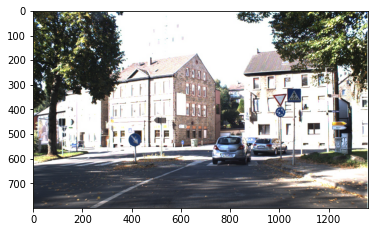

In [84]:
pil_img = Image.open('../dataset/00001.jpg')
plt.imshow(pil_img)

In [85]:
dfxi = df[df['img_path'] == '../dataset/00001.txt']
dfxi = dfxi[['cx', 'cy', 'bw', 'bh']].iloc[0]
dfxi

cx    1003.5
cy     410.0
bw      41.0
bh      44.0
Name: 1, dtype: float64

In [86]:
left = int(dfxi.cx - (dfxi.bw / 2))
top = int(dfxi.cy - (dfxi.bh / 2))
right = int(dfxi.cx + (dfxi.bw / 2))
bottom = int(dfxi.cy + (dfxi.bh / 2))
left, top

(983, 387)

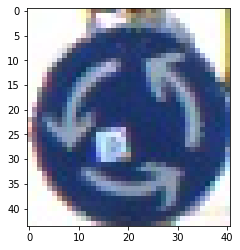

In [87]:
crop_img = pil_img.crop((left, top, right, bottom))
plt.imshow(crop_img)

In [88]:
cropped_np_img = np.asarray(crop_img)
cropped_np_img.shape

(44, 41, 3)

In [91]:
cal_mode(cropped_np_img[..., 2])

255

## Practice Block

In [ ]:
pil_img = Image.open('')
np_img = np.asarray(pil_img)
np_img.shape

In [ ]:
raf_img = np_img[..., 0]
gaf_img = np_img[..., 1]
baf_img = np_img[..., 2]

In [ ]:

idx, cnts

In [ ]:
np.argmax(cnts)

In [ ]:
idx[175]